In [1]:
%cd "/home/albin/skolarbete/DML_LAsegmentation"

/home/albin/skolarbete/DML_LAsegmentation


In [2]:
from scripts.train import train, validate, patched_forward
from scripts.utils import CombinedLoss
from models.unet import UNet3D
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from monai.networks.nets import UNETR
from transformers import get_cosine_schedule_with_warmup

from scripts.dataset import TrainDataset, TestDataset

In [3]:
train_image_path = 'data/Task02_Heart/imagesTr'
train_label_path = 'data/Task02_Heart/labelsTr'
val_image_path = 'data/Task02_Heart/imagesVl'
val_label_path = 'data/Task02_Heart/labelsVl'

patch_size = (64, 128, 128)
train_dataset = TrainDataset(
    train_image_path, 
    train_label_path,
    patch_size, 
    require_target=0.5, 
    preload_all_images=True, 
    num_patches_per_image=1, 
    transform=None, 
    scale_intensity=True
)
val_dataset = TestDataset(val_image_path, val_label_path, scale_intensity=True)

batch_size = 4
# The effective batch size will be batch_size * num_patches_per_image
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=4)

In [4]:
model = UNETR(in_channels=1, out_channels=1, img_size=patch_size)

epochs = 1000
validation_freq = 50

loss_fn = CombinedLoss(smooth=1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
total_steps = len(train_loader) * 1000
num_warmup_steps = total_steps//20
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=total_steps)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
results = train(model, optimizer, loss_fn, train_loader, val_loader, scheduler, device, epochs, patch_size=patch_size, validation_freq=validation_freq)

Starting training on device cuda...


/home/albin/miniconda3/envs/dml/lib/python3.11/site-packages/torch/_tensor.py:1443: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:84.)
  ret = func(*args, **kwargs)


Epoch 1 of 1000 took 2.32s | Training: loss=0.7530, iou=0.0529, dice=0.1003
Epoch 2 of 1000 took 1.85s | Training: loss=0.7489, iou=0.0599, dice=0.1129
Epoch 3 of 1000 took 1.84s | Training: loss=0.7482, iou=0.0648, dice=0.1201
Epoch 4 of 1000 took 1.83s | Training: loss=0.7450, iou=0.0647, dice=0.1213
Epoch 5 of 1000 took 1.89s | Training: loss=0.7396, iou=0.0729, dice=0.1352
Epoch 6 of 1000 took 1.94s | Training: loss=0.7396, iou=0.0680, dice=0.1258
Epoch 7 of 1000 took 1.82s | Training: loss=0.7299, iou=0.0895, dice=0.1641
Epoch 8 of 1000 took 1.83s | Training: loss=0.7292, iou=0.0743, dice=0.1351
Epoch 9 of 1000 took 1.86s | Training: loss=0.7271, iou=0.0744, dice=0.1376
Epoch 10 of 1000 took 1.84s | Training: loss=0.7300, iou=0.0606, dice=0.1133
Epoch 11 of 1000 took 1.81s | Training: loss=0.7271, iou=0.0567, dice=0.1063
Epoch 12 of 1000 took 1.84s | Training: loss=0.7113, iou=0.0817, dice=0.1497
Epoch 13 of 1000 took 1.82s | Training: loss=0.7053, iou=0.1033, dice=0.1855
Epoch 14

In [5]:
file_name = 'unetR_model_results.pkl'

# Check if 'results' exists in the local scope
if 'results' in locals():
    # Unpack and save the model's state dict and results
    with open(file_name, 'wb') as f:
        pickle.dump({
            'model_state': results[0].state_dict(),  # best_model state dict
            'train_metrics': results[1],  # results_train
            'val_metrics': results[2]    # results_val
        }, f)
    print(f"Results and model saved to {file_name}")

else:
    # Load the results and model state from the file
    with open(file_name, 'rb') as f:
        data = pickle.load(f)
        best_model = UNETR(in_channels=1, out_channels=1, img_size=(64 , 64 , 64))

        best_model.load_state_dict(data['model_state'])
        results = (best_model, data['train_metrics'], data['val_metrics'])
    print(f"Results and model loaded from {file_name}")

best_model, results_train, results_val = results

Results and model saved to unetR_model_results.pkl


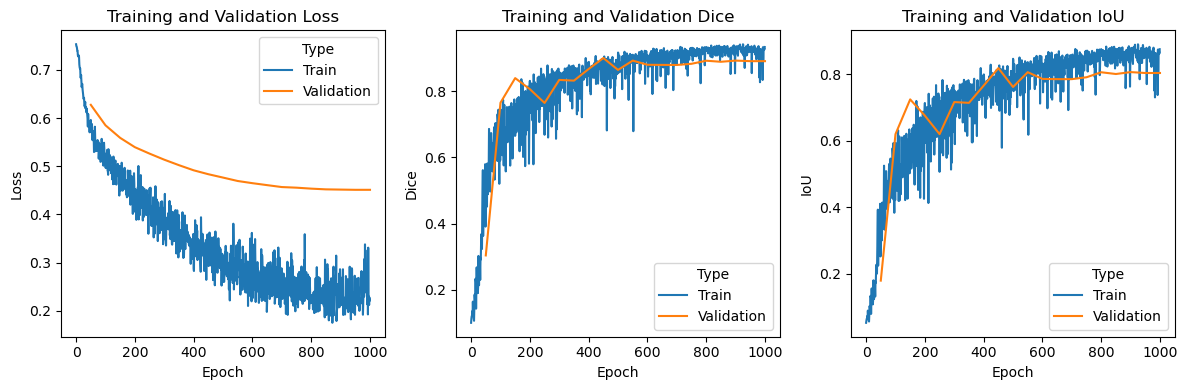

In [6]:
# Create DataFrames for easier plotting with Seaborn
df_train_loss = pd.DataFrame({'Epoch': range(len(results_train['loss'])), 'Value': results_train['loss'], 'Metric': 'Loss', 'Type': 'Train'})
df_val_loss = pd.DataFrame({'Epoch': [validation_freq * (1 + x) for x in range(len(results_val['loss']))], 'Value': results_val['loss'], 'Metric': 'Loss', 'Type': 'Validation'})

df_train_dice = pd.DataFrame({'Epoch': range(len(results_train['dice'])), 'Value': results_train['dice'], 'Metric': 'Dice', 'Type': 'Train'})
df_val_dice = pd.DataFrame({'Epoch': [validation_freq * (1 + x) for x in range(len(results_val['dice']))], 'Value': results_val['dice'], 'Metric': 'Dice', 'Type': 'Validation'})

df_train_iou = pd.DataFrame({'Epoch': range(len(results_train['iou'])), 'Value': results_train['iou'], 'Metric': 'IoU', 'Type': 'Train'})
df_val_iou = pd.DataFrame({'Epoch': [validation_freq * (1 + x) for x in range(len(results_val['iou']))], 'Value': results_val['iou'], 'Metric': 'IoU', 'Type': 'Validation'})

# Combine the DataFrames
df = pd.concat([df_train_loss, df_val_loss, df_train_dice, df_val_dice, df_train_iou, df_val_iou])

# Plot using Seaborn
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

sns.lineplot(data=df[df['Metric'] == 'Loss'], x='Epoch', y='Value', hue='Type', ax=axs[0])
axs[0].set_title('Training and Validation Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')

sns.lineplot(data=df[df['Metric'] == 'Dice'], x='Epoch', y='Value', hue='Type', ax=axs[1])
axs[1].set_title('Training and Validation Dice')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Dice')

sns.lineplot(data=df[df['Metric'] == 'IoU'], x='Epoch', y='Value', hue='Type', ax=axs[2])
axs[2].set_title('Training and Validation IoU')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('IoU')

plt.tight_layout()
plt.show()

In [7]:
image, label = val_dataset[0]
image = image.unsqueeze(0)
image = image.to(device)
with torch.no_grad():
    pred_logits = patched_forward(best_model, image, patch_size, 'cuda')
pred = torch.sigmoid(pred_logits)
pred = pred.squeeze(0, 1)
image = image.squeeze(0, 1)

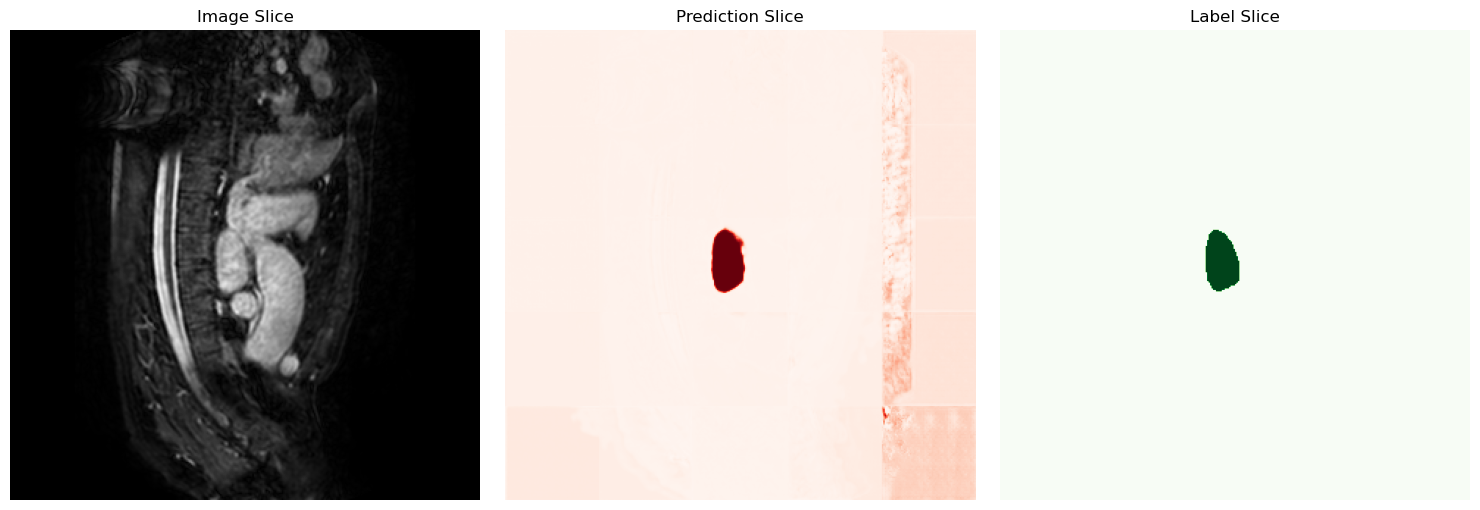

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Select the 50th slice along the first axis
slice_index = 80

image_slice = image[slice_index].cpu().numpy()
pred_slice = pred[slice_index].cpu().numpy()
label_slice = label[slice_index].cpu().numpy()

# Create the figure and the axes with 3 subplots side by side
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot the original image slice
axs[0].imshow(image_slice, cmap='gray')
axs[0].set_title('Image Slice')
axs[0].axis('off')

# Plot the prediction slice
axs[1].imshow(pred_slice, vmin=0, vmax=1, cmap='Reds')
axs[1].set_title('Prediction Slice')
axs[1].axis('off')

# Plot the label slice
axs[2].imshow(label_slice, cmap='Greens')
axs[2].set_title('Label Slice')
axs[2].axis('off')

# Display the figure
plt.tight_layout()
plt.show()


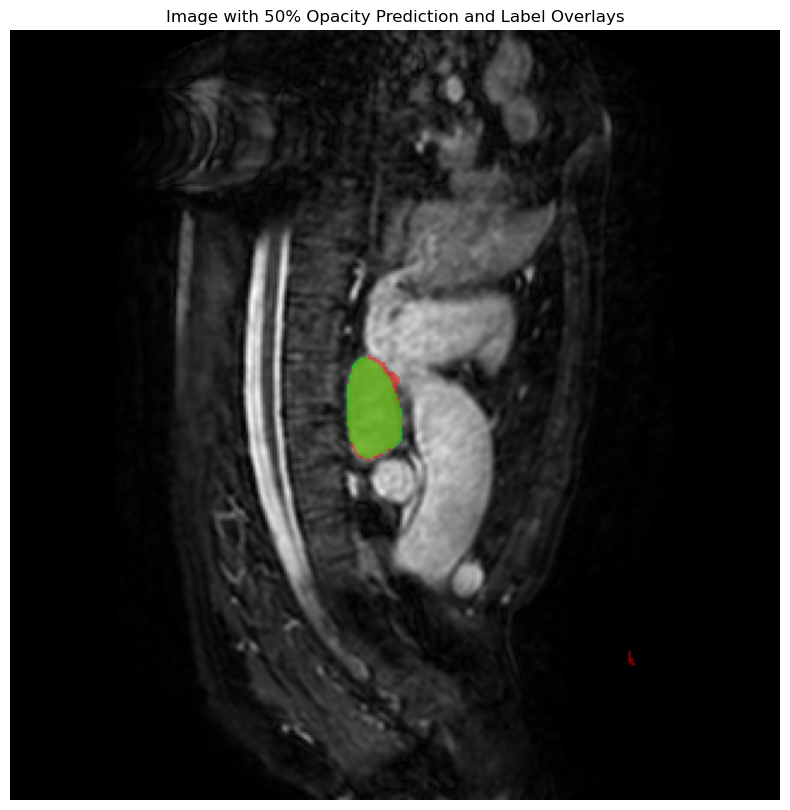

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Select the 50th slice along the first axis
slice_index = 80
image_slice = image[slice_index].cpu().numpy()
pred_slice = pred[slice_index].cpu().numpy()
label_slice = label[slice_index].cpu().numpy()

pred_slice = (pred_slice > 0.5).astype(np.float32)

# Normalize image slice for visualization (if needed)
image_slice = (image_slice - image_slice.min()) / (image_slice.max() - image_slice.min())

# Create an RGB image from the grayscale slice
image_rgb = np.stack([image_slice]*3, axis=-1)

# Create solid colors for the prediction and label overlays
red_overlay = np.zeros_like(image_rgb)
red_overlay[..., 0] = 1  # Red color for prediction

green_overlay = np.zeros_like(image_rgb)
green_overlay[..., 1] = 1  # Green color for label

# Create the prediction and label masks (expanding dims for compatibility)
pred_mask = np.expand_dims(pred_slice, axis=-1)
label_mask = np.expand_dims(label_slice, axis=-1)

# Set the opacity for the overlays (50% opacity)
opacity = 0.5

# Blend the solid color with the original image using the mask
# First, apply the red overlay for predictions
overlay_image = image_rgb * (1 - pred_mask * opacity) + red_overlay * pred_mask * opacity

# Then, apply the green overlay for labels
overlay_image = overlay_image * (1 - label_mask * opacity) + green_overlay * label_mask * opacity

# Plot the resulting image with the 50% opacity overlays
plt.figure(figsize=(10, 10))
plt.imshow(overlay_image)
plt.title('Image with 50% Opacity Prediction and Label Overlays')
plt.axis('off')
plt.show()
